#The curse of hunting rare things
###What are the chances of intersecting features with a grid of cross-sections?

I'd like to know the probability of intersecting features with a grid of cross-sections? These sections or transects might be 2D seismic lines, or outcrops.

This notebook goes with the Agile blog post — [The curse of hunting rare things](http://www.agilegeoscience.com/blog/2015/5/21/the-curse-of-hunting-rare-things) — from May 2015. 

## Linear sampling theory

I got this approach from [some lab notes by Dave Oleyar](http://www.webpages.uidaho.edu/wlf448/lab5line.htm) for an ecology class at the Unisity of Idaho. He in turn refers to the following publication:

> Buckland, S. T., Anderson, D. R., Burnham, K. P., and Laake, J. L. 1993. Distance sampling: estimating abundance of biological populations. Chapman and Hall, London.

The equation in the notes expresses density in terms of observations, but I was interested in the inverse problem: expected intersections given some population. Of course, we don't know the population, but we can tune our intuition with some modeling.

In [1]:
area = 120000.0      # km^2, area covered by transects
population = 120     # Total number of features (guess)
no_lines = 250       # Total number of transects
line_length = 150    # km, mean length of a transect
feature_width = 0.5  # km, width of features

density = population / area
length = no_lines * line_length

observed = 2 * density * length * feature_width
print "Expected number of features intersected:", observed

Expected number of features intersected: 37.5


Just for fun, we can — using the original formula in the reference — calculate the population size from an observation:

In [2]:
observed = 37.5
population = (observed * area) / (2. * length * feature_width)

print "Population:", population

Population: 120.0


It's a linear relationship, let's plot it.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

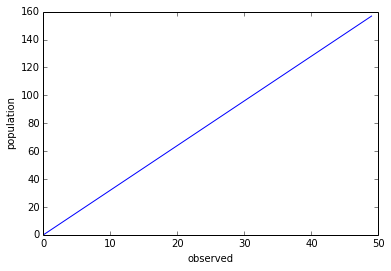

In [4]:
# Make that last expression into a quick function
def pop(obs, area, length, width):
    return (obs * area) / (2. * length * width)

# Pass in an array of values
obs = np.arange(50)
pop = pop(obs, area, length, feature_width)

plt.plot(obs, pop)
plt.xlabel('observed')
plt.ylabel('population')
plt.show()

<hr />
## Geometric reasoning

If we think of a 2D line, we can reason that if a feature lies more than its radius from the line then it is not intersected. Here's the situation for a grid:

<img src="https://dl.dropboxusercontent.com/u/14965965/2D-grid.png">

If there's a set of lines, then the problem is symmetric across the gaps between lines. The width of the 'invisible strip' (grey in the figure, which shows a grid rather than a swath) is the size of the gap minus the width of the feature. If we divide the width of the invisible strip by the width of the gap, we get a probability of randomly distributed features falling into the invisible strip.

### Parallel 2D lines

In [5]:
line_spacing = 3.0  # km, the width of the gap

# 'Invisible' means 'not intersected'
width_invisible = line_spacing - feature_width
prob_invisible = width_invisible / line_spacing
prob_visible = 1 - prob_invisible

print "Probability of intersecting a given feature:", prob_visible

Probability of intersecting a given feature: 0.166666666667


### Orthogonal grid of 2D lines

In [6]:
x_spacing = 3.0  # km
y_spacing = 3.0  # km

# Think of the quadrilaterals between lines as 'units'
area_of_unit = x_spacing * y_spacing
area_invisible = (x_spacing - feature_width) * (y_spacing - feature_width)
area_visible = area_of_unit - area_invisible
prob_visible = area_visible / area_of_unit

print "Probability of intersecting a given feature:", prob_visible

Probability of intersecting a given feature: 0.305555555556


We're going to need a binomial distribution, `scipy.stats.binom`.

In [7]:
import scipy.stats

We can use the distribution to estimate the probability of seeing no features. Then we can use the survival function (or, equivalently, 1 - the cumulative distribution function), `sf(x, n, p)`, to tell us the probability of drawing more than *x* in *n* trials, given a success probability *p*:

In [8]:
p = "Probability of intersecting"
print p, "no features:", scipy.stats.binom.pmf(0, population, prob_visible)
print p, "at least one:", scipy.stats.binom.sf(0, population, prob_visible)
print p, "at least two:", scipy.stats.binom.sf(1, population, prob_visible)
print p, "all features:", scipy.stats.binom.sf(population-1, population, prob_visible)

Probability of intersecting no features: 9.91975505873e-20
Probability of intersecting at least one: 1.0
Probability of intersecting at least two: 1.0
Probability of intersecting all features: 1.62488311945e-62


<hr />
## Interpretation accuracy

We can apply Bayes' theorem to update the prior probability (above) with the reliability of our interpretation (due to lack of resolution, data quality, or skill). 

In [9]:
reliability = 0.75
trials = 120

intersect_interpret = prob_visible * reliability * trials
intersect_xinterpret = prob_visible * (1 - reliability) * trials
xintersect_interpret = (1 - prob_visible) * (1 - reliability) * trials
xintersect_xinterpret = (1 - prob_visible) * reliability * trials

t = [[intersect_interpret, intersect_xinterpret], [xintersect_interpret, xintersect_xinterpret]]

We can use a `pandas` DataFrame to show a quick table:

In [10]:
from pandas import DataFrame
df = DataFrame(t, index=['Intersected', 'Not intersected'], columns=['Interpreted','Not interpreted'])
df

,Interpreted,Not interpreted
Intersected,27.500000,9.166667
Not intersected,20.833333,62.500000


We can compute the probability of a given feature being correctly interpreted:

In [11]:
prob_correct = intersect_interpret / (intersect_interpret + xintersect_interpret)
print "Probability of a feature existing if interpreted:", prob_correct

Probability of a feature existing if interpreted: 0.568965517241


<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="50px" /><p style="color:gray; float:right;">© 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>